In [62]:
# import pandas as pd
import vectorbt as vbt
from datetime import datetime,timedelta
import pytz
import numpy as np
# Enter your parameters here
seed = 42
symbol = 'BTC-USD'
metric = 'total_return'

start_date = datetime(2018, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime(2020, 1, 1, tzinfo=pytz.utc)
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1D'

vbt.settings.portfolio['init_cash'] = 100.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

# Download data with time buffer
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_wbuf = vbt.YFData.download(symbol, start=start_date-time_buffer, end=end_date).get(cols)

ohlcv_wbuf = ohlcv_wbuf.astype(np.float64)

In [63]:
ohlcv_wbuf['Close']

Date
2017-09-23 00:00:00+00:00    3792.399902
2017-09-24 00:00:00+00:00    3682.840088
2017-09-25 00:00:00+00:00    3926.070068
2017-09-26 00:00:00+00:00    3892.350098
2017-09-27 00:00:00+00:00    4200.669922
                                ...     
2019-12-27 00:00:00+00:00    7290.088379
2019-12-28 00:00:00+00:00    7317.990234
2019-12-29 00:00:00+00:00    7422.652832
2019-12-30 00:00:00+00:00    7292.995117
2019-12-31 00:00:00+00:00    7193.599121
Freq: D, Name: Close, Length: 830, dtype: float64

In [72]:
def apply_strategy(price_data):
    buy_threshold= 7000
    sell_threshold= 9000
    entry_signals = []
    exit_signals = []

    for price in price_data:
        if price < buy_threshold:
            entry_signals.append(True)
            exit_signals.append(False)
        elif price > sell_threshold:
            entry_signals.append(False)
            exit_signals.append(True)
        else:
            entry_signals.append(False)
            exit_signals.append(False)

    return entry_signals, exit_signals

# Apply the strategy to generate signals
entries,exits = apply_strategy(ohlcv_wbuf['Close'].values)

df=pd.concat([ohlcv_wbuf, pd.DataFrame(entries,index=ohlcv_wbuf.index,columns=['entry'])], axis=1)
df=pd.concat([df, pd.DataFrame(exits,index=ohlcv_wbuf.index,columns=['exit'])], axis=1)


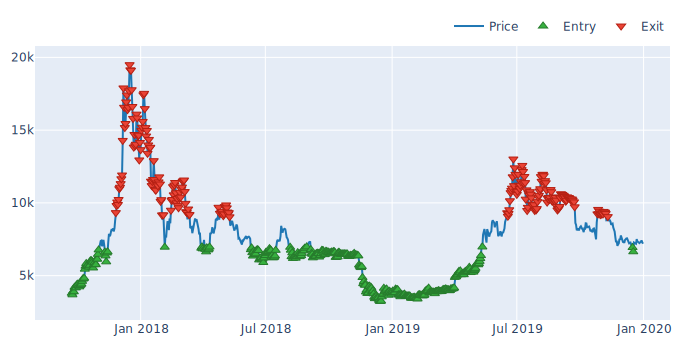

In [73]:
fig = df['Close'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = df['entry'].vbt.signals.plot_as_entry_markers(ohlcv_wbuf['Close'], fig=fig)
fig = df['exit'].vbt.signals.plot_as_exit_markers(ohlcv_wbuf['Close'], fig=fig)

fig.show_svg()

In [75]:
dmac_pf = vbt.Portfolio.from_signals(df['Close'], df['entry'], df['exit'])

In [84]:
dmac_pf.value()

Date
2017-09-23 00:00:00+00:00     99.501869
2017-09-24 00:00:00+00:00     96.627328
2017-09-25 00:00:00+00:00    103.008997
2017-09-26 00:00:00+00:00    102.124280
2017-09-27 00:00:00+00:00    110.213722
                                ...    
2019-12-27 00:00:00+00:00    652.658062
2019-12-28 00:00:00+00:00    655.156025
2019-12-29 00:00:00+00:00    664.526129
2019-12-30 00:00:00+00:00    652.918293
2019-12-31 00:00:00+00:00    644.019690
Freq: D, Length: 830, dtype: float64

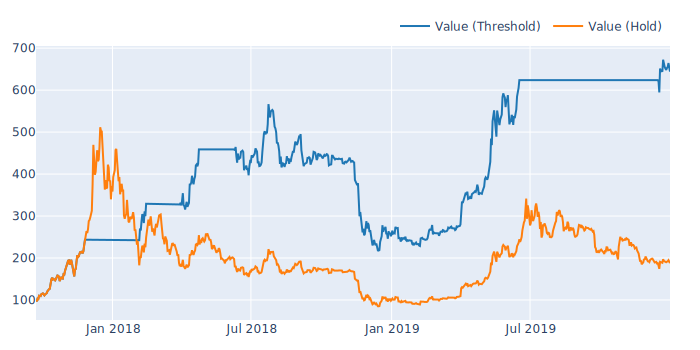

In [78]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and sell at the end
hold_entries = pd.Series.vbt.signals.empty_like(df['entry'])
hold_entries.iloc[0] = True
hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
hold_exits.iloc[-1] = True
hold_pf = vbt.Portfolio.from_signals(df['Close'], hold_entries, hold_exits)

# Equity
fig = dmac_pf.value().vbt.plot(trace_kwargs=dict(name='Threshold Buy/Sell'))
hold_pf.value().vbt.plot(trace_kwargs=dict(name='Hold'), fig=fig).show_svg()

In [83]:
fig = df['Close'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = dmac_pf.vbt.signals.plot_as_entry_markers(ohlcv_wbuf['Close'], fig=fig)
fig = dmac_pf.vbt.signals.plot_as_exit_markers(ohlcv_wbuf['Close'], fig=fig)

fig.show_svg()

AttributeError: 'Portfolio' object has no attribute 'vbt'